In [1]:
import h5py
import numpy as np
from blutils.fit_2dgaussians import fit_gaussian_to_imgs
from scipy.optimize import curve_fit
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float

In [ ]:
path = r'C:/Users/alba.gomez.segalas/Documents/MF3 measurements/2024-03-01 beam monitor'
filename = 'AR2-BR2-AR2-BR1.h5'
hf = h5py.File(path + '/' + filename, 'r')

### First implementation (suitable for 2 maxima in image) ###

In [ ]:
def mask_image(image, box_size):
    # Split the image into left and right halves
    image_left = image[:, :image.shape[1] // 2]
    image_right = image[:, image.shape[1] // 2:]

    # Find the global maximum in each half
    max_left = np.max(image_left)
    max_right = np.max(image_right)

    # Find the coordinates of the global maximum in each half
    max_left_coords = np.argwhere(image_left == max_left)[0]
    max_right_coords = np.argwhere(image_right == max_right)[0]

    # Calculate the coordinates of the top-left corner of the box for each half
    left_box_x = max_left_coords[0] - box_size // 2
    left_box_y = max_left_coords[1] - box_size // 2
    right_box_x = max_right_coords[0] - box_size // 2
    right_box_y = max_right_coords[1] - box_size // 2

    # Mask the left half of the image
    masked_image_left = image_left.copy()
    masked_image_left = image_left[left_box_x:left_box_x + box_size, left_box_y:left_box_y + box_size]

    # Mask the right half of the image
    masked_image_right = image_right.copy()
    masked_image_right = image_right[right_box_x:right_box_x + box_size, right_box_y:right_box_y + box_size]

    return masked_image_left, masked_image_right

def plot_images(image, masked_image_left, masked_image_right):
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Plot the full image
    axs[0][0].imshow(image)
    axs[0][0].set_title('Full Image')

    # Plot the masked image on the left
    axs[0][1].imshow(masked_image_left)
    axs[0][1].set_title('Masked Image (Left)')

    # Plot the masked image on the right
    axs[0][2].imshow(masked_image_right)
    axs[0][2].set_title('Masked Image (Right)')

    axs[1][0].plot(image[image.shape[0] // 2, :])
    axs[1][1].plot(masked_image_left[masked_image_left.shape[0] // 2, :])
    axs[1][2].plot(masked_image_right[masked_image_right.shape[0] // 2, :])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

data = hf['Stacks/movie'][...].astype(np.float32) # convert HDF5 dataset to numpy array

avr = 100 # number of frames to average
starts = np.arange(0, data.shape[0], avr)
slices = np.array([slice(start, start + avr) for start in starts])

box_size = 50 # box size for masking

masked_image_left = np.zeros(shape=(len(slices),box_size,box_size),dtype=np.float32)
masked_image_right = np.zeros(shape=(len(slices),box_size,box_size),dtype=np.float32)

for i, slice in enumerate(slices):
    im = np.mean(data[slice], axis=0)
    masked_image_left[i], masked_image_right[i] = mask_image(im, box_size)
    
i = 0 
image = np.mean(data[slices[i]], axis=0)
plot_images(image, masked_image_left[i], masked_image_right[i])

In [ ]:
image_left = image[:, :image.shape[1] // 2]
image_right = image[:, image.shape[1] // 2:]

# Find the global maximum in each half
max_left = np.max(image_left)
max_right = np.max(image_right)

# Find the coordinates of the global maximum in each half
max_left_coords = np.argwhere(image_left == max_left)[0]
max_right_coords = np.argwhere(image_right == max_right)[0]

# Calculate the coordinates of the top-left corner of the box for each half
left_box_x = max_left_coords[0] - box_size // 2
left_box_y = max_left_coords[1] - box_size // 2
right_box_x = max_right_coords[0] - box_size // 2
right_box_y = max_right_coords[1] - box_size // 2

fig, axs = plt.subplots(1,2,figsize=(5, 5))

axs[0].imshow(image_left)
axs[0].set_xlim(0, image_left.shape[1])
axs[0].set_ylim(0, image_left.shape[0])
axs[0].hlines([left_box_x, left_box_x+box_size], xmin=0, xmax=image_left.shape[1], color='r')
axs[0].vlines([left_box_y, left_box_y+box_size], ymin=0, ymax=image_left.shape[0], color='k')

axs[1].imshow(image_right)
axs[1].set_xlim(0, image_right.shape[1])
axs[1].set_ylim(0, image_right.shape[0])
axs[1].hlines([right_box_x, right_box_x+box_size], xmin=0, xmax=image_right.shape[1], color='r')
axs[1].vlines([right_box_y, right_box_y+box_size], ymin=0, ymax=image_right.shape[0], color='k')

### Implementation for general number of maxima ###

In [3]:
def img_around_peak(image, peak, width):
    """Return a subimage around the peak, with a given width."""
    row, col = peak
    img = image[row-width//2:row+width//2, col-width//2:col+width//2]
    return img

def create_cpufit_input(data, num_peaks, coordinates, average, width):
    starts = np.arange(0, data.shape[0], average)
    slices = np.array([slice(start, start + average) for start in starts])

    cpufit_input = np.zeros((len(slices)*num_peaks, width, width), dtype=np.float32)

    for i, s in enumerate(slices):
        image = np.mean(data[s], axis=0)
        for j, peak in enumerate(coordinates):
            cpufit_input[i*num_peaks+j] = img_around_peak(image=image, peak=peak, width=width)

    return cpufit_input

Indices of the highest local maxima: [[150 118]
 [114 118]
 [131  99]
 [132 137]]


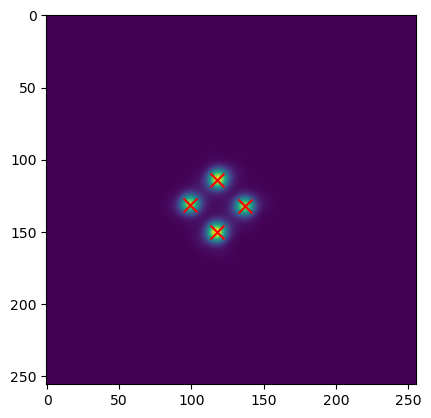

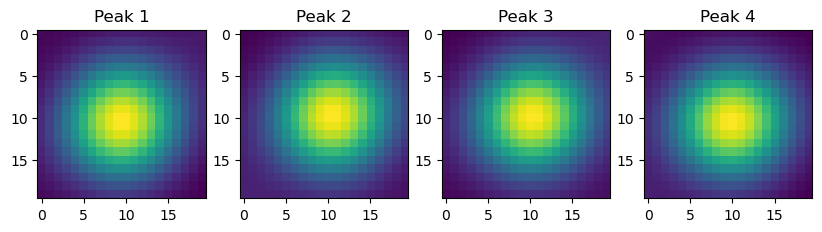

In [6]:
# Select first frame of stack
image = hf['Stacks/movie'][0].astype(np.float32) 
image = ndi.gaussian_filter(image, sigma=3)  

# Define number of peaks in image
num_peaks = 4 

# Find coordinates of peaks
coordinates = peak_local_max(image, min_distance=10, num_peaks=num_peaks)
print("Indices of the highest local maxima:", coordinates)

# def peak_coords(image, num_peaks=4):
#     """Return the coordinates of the highest local maxima in the image."""
#     image = ndi.gaussian_filter(image, sigma=3)  
#     coordinates = peak_local_max(image, min_distance=10, num_peaks=num_peaks)
#     return coordinates

plt.imshow(image)
plt.scatter(coordinates[:, 1], coordinates[:, 0], s=100, c='r', marker='x')

width = 20 # width of squared subimage around the peak

fig, axs = plt.subplots(1,num_peaks,figsize=(10,10))
for i, peak in enumerate(coordinates):
    ax = axs[i]
    ax.imshow(img_around_peak(image, peak, width))
    ax.set_title(f"Peak {i+1}")
plt.show()

### Gaussian CPU fit ###

In [7]:
# Convert HDF5 dataset to numpy array
data = hf['Stacks/movie'][...].astype(np.float32) 
average = 100
width = 20

cpufit_input = create_cpufit_input(data, num_peaks=num_peaks, coordinates=coordinates, average=average, width=width)
chunk_size = 10
parameters, chi_sq = fit_gaussian_to_imgs(cpufit_input, chunk_size=chunk_size)

### Fit analysis ###

In [9]:
from sklearn.metrics import mean_squared_error

def two_dimensional_gaussian(x, y, amplitude, x0, y0, sigma_x, sigma_y, offset):
    """
    Compute a two-dimensional Gaussian function.
    
    Parameters:
    - x, y: 1D arrays representing the x and y coordinates
    - amplitude: amplitude of the Gaussian
    - x0, y0: center coordinates of the Gaussian
    - sigma_x, sigma_y: standard deviations in x and y directions
    - offset: amplitude offset
    
    Returns:
    - 2D array representing the computed Gaussian function
    """
    x_term = (x - x0) ** 2 / (2 * sigma_x ** 2)
    y_term = (y - y0) ** 2 / (2 * sigma_y ** 2)
    gaussian = amplitude * np.exp(-(x_term + y_term)) + offset
    return gaussian


# i = 0
# # Plot masked left and right images with Gaussian fits
# fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# # Plot masked left image
# im0 = axs[0][0].imshow(masked_image_left[i])
# fig.colorbar(im0, ax=axs[0][0])
# axs[0][0].set_title('Masked Image (Left)')

# # Plot masked right image
# im1 = axs[0][1].imshow(masked_image_right[i])
# fig.colorbar(im1, ax=axs[0][1])
# axs[0][1].set_title('Masked Image (Right)')

# # Plot Gaussian fit for masked left image
# x = np.arange(masked_image_left[i].shape[1])
# y = np.arange(masked_image_left[i].shape[0])
# X, Y = np.meshgrid(x, y)
# Zl = two_dimensional_gaussian(X, Y, *parameters[i][:6])
# im2 = axs[1][0].imshow(np.abs(masked_image_left[i]-Zl)/np.max(masked_image_left[i]))
# fig.colorbar(im2, ax=axs[1][0])
# axs[1][0].set_title('Fit Error (Left)')

# # Plot Gaussian fit for masked right image
# Zr = two_dimensional_gaussian(X, Y, *parameters[len(slices)+i][:6])
# im3 = axs[1][1].imshow(np.abs(masked_image_right[i]-Zr)/np.max(masked_image_right[i]))
# fig.colorbar(im3, ax=axs[1][1])
# axs[1][1].set_title('Fit Error (Right)')

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

In [ ]:
# 1D plots
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0][0].plot(masked_image_left[i][box_size // 2, :])
axs[0][0].plot(Zl[box_size // 2, :])
axs[0][0].set_title('Horizontal profile (Left)')
axs[1][0].plot(masked_image_left[i][:, box_size // 2])
axs[1][0].plot(Zl[:, box_size // 2])
axs[1][0].set_title('Vertical profile (Left)')
axs[0][1].plot(masked_image_right[i][box_size // 2, :])
axs[0][1].plot(Zr[box_size // 2, :])
axs[0][1].set_title('Horizontal profile (Right)')
axs[1][1].plot(masked_image_right[i][:, box_size // 2])
axs[1][1].plot(Zr[:, box_size // 2])
axs[1][1].set_title('Vertical profile (Right)')
plt.tight_layout()
plt.show()

The random group is: 8


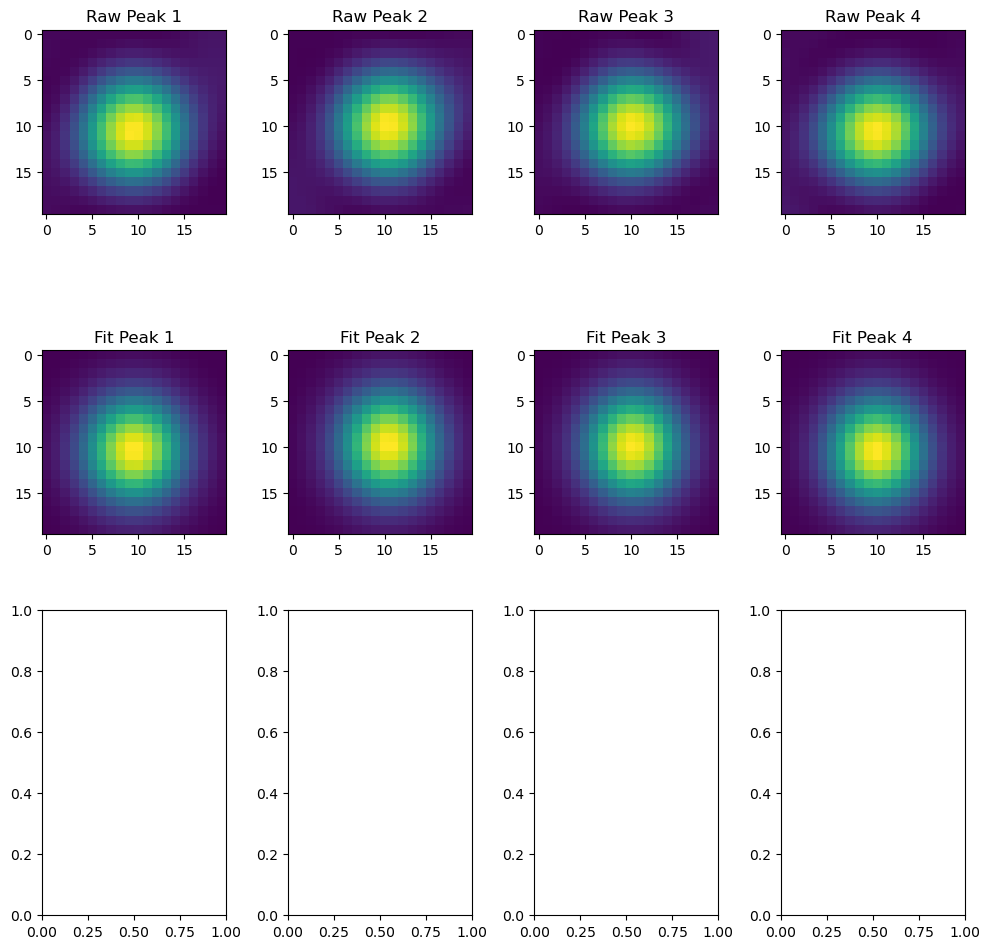

In [10]:
# Select randomly a group of averaged frames
gr = data.shape[0]/average
if int(gr) != gr:
    gr = int(gr) + 1
else:
    pass
random_gr = np.random.choice(np.arange(gr+1))
print('The random group is:', random_gr)

x, y = np.arange(width), np.arange(width)
X, Y = np.meshgrid(x, y)

fig, axs = plt.subplots(3,num_peaks,figsize=(10,10))
for i, peak in enumerate(coordinates):
    raw_peak = cpufit_input[i+num_peaks*random_gr]
    axs[0][i].imshow(raw_peak)
    axs[0][i].set_title(f"Raw Peak {i+1}")
    fit_peak = two_dimensional_gaussian(X, Y, *parameters[i+num_peaks*random_gr][:6])
    axs[1][i].imshow(two_dimensional_gaussian(X, Y, *parameters[i+num_peaks*random_gr][:6]))
    axs[1][i].set_title(f"Fit Peak {i+1}")
    axs[2][i]

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

def two_dimensional_gaussian(x, y, amplitude, x0, y0, sigma_x, sigma_y, offset):
    """
    Compute a two-dimensional Gaussian function.
    
    Parameters:
    - x, y: 1D arrays representing the x and y coordinates
    - amplitude: amplitude of the Gaussian
    - x0, y0: center coordinates of the Gaussian
    - sigma_x, sigma_y: standard deviations in x and y directions
    - offset: amplitude offset
    
    Returns:
    - 2D array representing the computed Gaussian function
    """
    x_term = (x - x0) ** 2 / (2 * sigma_x ** 2)
    y_term = (y - y0) ** 2 / (2 * sigma_y ** 2)
    gaussian = amplitude * np.exp(-(x_term + y_term)) + offset
    return gaussian



### Drift analysis ###

In [ ]:
plt.figure()
plt.plot(parameters[:len(slices), 1], label='x0', linestyle = '-', color='r')
plt.plot(parameters[:len(slices), 2], label='y0', linestyle = ':', color='r')
plt.plot(parameters[len(slices):, 1], label='x1', linestyle = '-', color='k')
plt.plot(parameters[len(slices):, 2], label='y1', linestyle = ':', color='k')
plt.legend()
plt.show()

### Test subparts of CPU fitting code 

In [ ]:
nfit = 120
chunk_size = 50
np.linspace(0,nfit,np.ceil(nfit/chunk_size).astype(int)+1)